In [2]:
%matplotlib inline
import os
from os.path import join as pjoin
from tifffile import imread, imwrite, TiffFile
import numpy as np
import shutil
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import cv2
from tqdm import tqdm
import subprocess
from wf_utils import filename2int, log_progress
# from wfield_utils import *
# from multi_load_images import *


In [3]:
### Set the file path

# path_0: including one-day recording files
# path_1: including every stimuli
# path_0 = r"/home/lzx/data/WF_VC_liuzhaoxi/P76/20240718"
path_0 = r"/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718"
path_1_ = os.listdir(path_0)
# 筛选出文件夹
path_1 = [folder for folder in path_1_ if os.path.isdir(pjoin(path_0, folder))]
path_all = []
for path in path_1:
    path_all.append(pjoin(path_0, path))

print('All the file path:\n'+str(path_all))


All the file path:
['/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/checkerboard-bar', '/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/looming', '/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/moving-bar_wrx', '/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/moving-dots', '/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/natural-movie', '/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/natural-movie-reverse', '/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/retinotopy', '/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/RF46']


In [ ]:
# ### re-organize files

# for path in path_all:
#     if not os.path.exists(pjoin(path, 'raw')):
#         os.mkdir(pjoin(path, 'raw'))
#     if not os.path.exists(pjoin(path, 'process/')):
#         os.mkdir(pjoin(path, 'process/'))
        
# for path in path_all:
#     files = glob(pjoin(path, '202?????-??????*'))
#     for file in files:
#         shutil.move(file, pjoin(path, 'raw', os.path.basename(file)))
#         print('moving',file)

# print('Moving raw data folders all finished!')


In [ ]:
### generate 2-channel tif stack

def organize_tif(folder_path):
    folder_name = os.path.basename(folder_path)
    if os.path.exists(folder_path+'.tif'):
        print('importing {}.tif'.format(folder_path))
        image_stack = imread(folder_path+'.tif')
        print('finish importing {}.tif'.format(folder_path))
    else:
        image_path_ls = glob(pjoin(folder_path, '*.tif'))
        image_path_ls = sorted(image_path_ls, key = filename2int) # 确保图像帧按顺序排列
        image_stack = [imread(tiff) for tiff in log_progress(image_path_ls, name=folder_name)]  # 将多帧tif堆叠成数组
        # image_stack = multi_load_images(image_path_ls, n_thread=20)
    # rotated_images = [cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) for frame in image_stack]   # 顺时针旋转图像90度
    # 计算并保存均值数据
    mean_values = [np.mean(frame) for frame in image_stack]
    output_value = pjoin(processPath, folder_name + "-Values.csv")
    np.savetxt(output_value, mean_values, delimiter=",")
    
    return np.array(image_stack)


for path in [path_all[0]]:
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    # 列出experiments
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiments = list(set([os.path.basename(item)[:15] for item in items]))
    print("experiments:")
    print(experiments)
    
    # 遍历每个experiment，merge channel
    for experiment in experiments:
        os.makedirs(pjoin(processPath, experiment+"-wfield"), exist_ok=True)
        mergePath = pjoin(processPath, experiment+"-wfield")
        merge_file = pjoin(mergePath, experiment+"-merged.tif")
        # if not os.path.exists(merge_file):
        tif_405 = organize_tif(pjoin(rawPath, experiment + "-405"))
        tif_470 = organize_tif(pjoin(rawPath, experiment + "-470"))
        tif_405_path = pjoin(mergePath, experiment + "-405.tif")
        tif_470_path = pjoin(mergePath, experiment + "-470.tif")
            # 检查两个通道的深度是否一致
            # if tif_405.shape[0] != tif_470.shape[0]:
            #     n_frames = min(tif_405.shape[0], tif_470.shape[0])
            #     tif_405 = tif_405[:n_frames]
            #     tif_470 = tif_470[:n_frames]
            # 将Tiff stack的数据从三维变成四维，不同通道使用第二维区分
            # merged_tif = np.concatenate((tif_470[:, np.newaxis], tif_405[:, np.newaxis]), axis=1)
            # 将合并后的图像保存为一个2通道Tiff图像
            # imwrite(merge_file, merged_tif)
        imwrite(tif_405_path, tif_405)
        imwrite(tif_470_path, tif_470)
                        
        # else: print("merged "+experiment+" has existed")
        # plotFluor(path, experiment)
        
    mean_values_405 = pjoin(path, "process", '{}-405-Values.csv'.format(experiment))
    mean_values_470 = pjoin(path, "process", '{}-470-Values.csv'.format(experiment))
    # read data from csv file as numpy array
    mean_values_405 = np.loadtxt(mean_values_405, delimiter=',')
    mean_values_470 = np.loadtxt(mean_values_470, delimiter=',')

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(mean_values_405, label='405')
    ax.plot(mean_values_470, label='470')
    ax.legend()
    plt.show()
    
# print("All merging finished!")


Check and replace outliers

In [41]:
path_all[6]

'/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/retinotopy'

Path: /home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/retinotopy
experiments:
['20240718-161348']


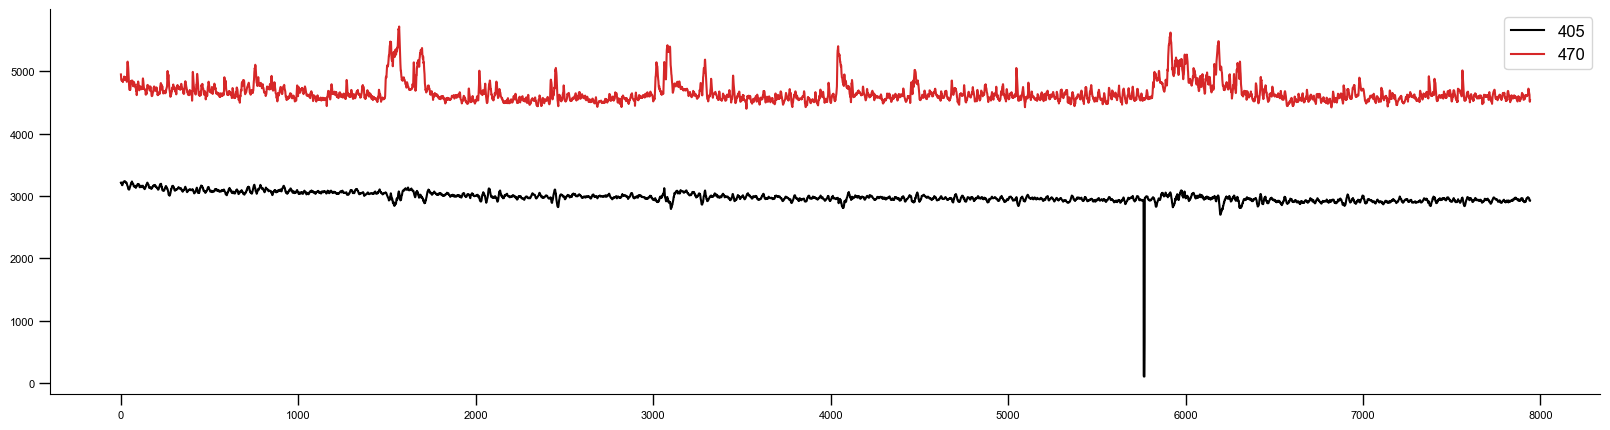

In [42]:
for path in [path_all[6]]:
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    # 列出experiments
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiments = list(set([os.path.basename(item)[:15] for item in items]))
    print("experiments:")
    print(experiments)
    
    # 遍历每个experiment，merge channel
    for experiment in experiments:

        values_405_path = pjoin(path, "process", '{}-405-Values.csv'.format(experiment))
        values_470_path = pjoin(path, "process", '{}-470-Values.csv'.format(experiment))
        # read data from csv file as numpy array
        mean_values_405 = np.loadtxt(values_405_path, delimiter=',')
        mean_values_470 = np.loadtxt(values_470_path, delimiter=',')

        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(mean_values_405, label='405')
        ax.plot(mean_values_470, label='470')
        ax.legend()
        plt.show()

In [43]:
outlier_405 = mean_values_405 < np.mean(mean_values_405)*0.3
outlier_index_405 = np.where(outlier_405)[0]
print(outlier_index_405)

outlier_470 = mean_values_470 < np.mean(mean_values_470)*0.3
outlier_index_470 = np.where(outlier_470)[0]
print(outlier_index_470)

[5764 5765 5766 5767 5768 5769]
[]


In [44]:
if len(outlier_index_405) > 0 or len(outlier_index_470) > 0:
    print('Outliers detected!')
    print('Outliers in 405: ', outlier_index_405)
    print('Outliers in 470: ', outlier_index_470)
    mergePath = pjoin(processPath, experiment+"-wfield")

    merge_file = pjoin(mergePath, experiment+"-merged.tif")
    print(merge_file)

    print('Reading the merged tif file...')
    images = imread(merge_file)

    if len(outlier_470) > 0:
        # replace the outlier images with the mean of the previous and next images
        for i in outlier_index_470:
            images[i, 0, :, :] = images[outlier_index_470[0]-1, 0, :, :]

    if len(outlier_405) > 0:
        # replace the outlier images with the mean of the previous and next images
        for i in outlier_index_405:
            images[i, 1, :, :] = images[outlier_index_405[0]-1, 1, :, :]

    print('Saving the merged tif file...')
    imwrite(merge_file, images, imagej=True, bigtiff=True)

# for test
# images = imread(merge_file, key=outlier_index_405*2+1)

Outliers detected!
Outliers in 405:  [5764 5765 5766 5767 5768 5769]
Outliers in 470:  []
/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/retinotopy/process/20240718-161348-wfield/20240718-161348-merged.tif
Reading the merged tif file...
Saving the merged tif file...


/home/wrx/.conda/envs/wfield/lib/python3.11/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20240718-161348-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


In [61]:
from ipywidgets import interact

def display_wrapper(images):
    def display_images(frame):
    
        plt.figure(figsize=(6, 6))
        plt.imshow(images[frame], cmap='gray')
        plt.axis('off')
        plt.show()

    frame_slider = interact(display_images, frame=(0, len(images)-1, 1))
    display(frame_slider)

# display_wrapper(images)

prepressing data

In [5]:
path_wfield_all = glob(pjoin(path_0, '*/process/*-wfield'))
print('All the wfield-path:\n'+"\n".join(path_wfield_all))

All the wfield-path:
/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/checkerboard-bar/process/20240718-162936-wfield
/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/looming/process/20240718-181900-wfield
/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/moving-bar_wrx/process/20240718-164038-wfield
/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/moving-dots/process/20240718-182235-wfield
/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/natural-movie/process/20240718-170059-wfield
/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/natural-movie-reverse/process/20240718-173530-wfield
/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/retinotopy/process/20240718-161348-wfield
/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/RF46/process/20240718-164748-wfield


In [8]:
### 生成trial_onsets.npy

n_movie_rep = 5

for path_wfield in [path_wfield_all[0]]:
    
    experiment = os.path.basename(path_wfield)[:15]
    rawPath = pjoin(path_wfield,'../../raw')
    merge_file = pjoin(path_wfield, experiment+"-merged.tif")
    n_frames = len(TiffFile(merge_file).pages)//2

    if os.path.exists(pjoin(rawPath, experiment + ".csv")):
        # generate trial_onsets.npy
        # trial_onsets.npy is a Nx3 array. The columns are: trial number, onset of the trial (frame index), offset of the trial.
        if not os.path.exists(pjoin(path_wfield, 'trials.csv')):
            stimfile = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
            stim_delay = pd.read_csv(pjoin(rawPath, experiment + "-470Timestamp.csv"), header=None).values
            stim_delay = int(stim_delay[0]/10)
            
            stim = np.zeros(n_frames)
            for i in range(n_frames):
                stim[i] = stimfile[(i * 10 + stim_delay), 0]
            single_0_indices = np.where((np.diff(np.append(stim, 0)) == 1) & (np.diff(stim, prepend=0) == -1))[0]
            single_1_indices = np.where((np.diff(np.append(stim, 0)) == -1) & (np.diff(stim, prepend=0) == 1))[0]
            stim[single_1_indices] = 0
            stim[single_0_indices] = 1
            
            onset = np.where(np.diff(stim) == 1)[0] + 1
            offset = np.where(np.diff(stim) == -1)[0] + 1
            trials_csv = np.stack((np.arange(len(onset)), onset, offset, offset-onset), axis=1)  # 这个用来自己检查一下以及自己后续分析
            np.savetxt(pjoin(path_wfield, "trials.csv"), trials_csv, delimiter=",")
            print("generate trials.csv of "+experiment)
            
            if 'retinotopy' in path_wfield:
                trial_onsets = np.stack((np.arange(len(onset)), onset - 30, offset), axis=1)  # 这个文件给wfield软件做SVD用
                np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)
            
            elif 'natural-movie' in path_wfield:
                n_movie = len(onset)//n_movie_rep
                trial_onsets = np.empty((n_movie,3))
                for i in range(n_movie):
                    trial_onsets[i] = [i, onset[i*n_movie_rep] - 100, offset[i*n_movie_rep]]
                np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
            # elif 'speed' in path_wfield:
            #     trial_onsets = [0, onset[0] - 100, offset[0]]
            #     np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
        else: print("trials.csv of "+experiment+" has existed")

    else: print(experiment, 'without stim-file, skip')
            
print("\nAll generation of trials-file finished!")


generate trials.csv of 20240718-162936

All generation of trials-file finished!


/tmp/ipykernel_11244/3234507067.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stim_delay = int(stim_delay[0]/10)


Computes baseline

In [21]:
path_wfield_all[6]

'/home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/retinotopy/process/20240718-161348-wfield'

In [23]:
tif_path = glob(pjoin(path_wfield_all[6],'*.tif'))[0]
print('reading tif file:', tif_path)
dat = imread(tif_path)
print(dat.shape)

reading tif file: /home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/retinotopy/process/20240718-161348-wfield/20240718-161348-merged.tif
(7942, 2, 512, 512)


In [56]:
def frames_average_for_trials(dat,onsets,nbaseline_frames):
    # from .utils import runpar
    if hasattr(dat,'filename'):
        dims = dims = dat.shape[1:]
        dat_path = dat.filename
        frames_average = runpar(compute_trial_baseline_from_binary,onsets,
                                filename = dat_path,
                                shape=dims,
                                nbaseline_frames=nbaseline_frames,
                                dtype = dat.dtype)
    else:
        frame_averages = []
        for on in tqdm(onsets):
            frame_averages.append(dat[on:on+nbaseline_frames].mean(axis=0))
    return np.stack(frame_averages)

In [58]:
trial_onsets = np.load(pjoin(path_wfield_all[6], 'trial_onsets.npy')).astype(int)
frames_average_trials = frames_average_for_trials(dat,
                                           trial_onsets[:,2],
                                           nbaseline_frames)
# Compute the average of all trials and save it
np.save(pjoin(path_wfield_all[6],'frames_average.npy'),frames_average_trials.mean(axis=0))

100%|██████████| 40/40 [00:01<00:00, 28.46it/s]


In [64]:
display_wrapper(frames_average_trials[:, 0, :, :])

interactive(children=(IntSlider(value=19, description='frame', max=39), Output()), _dom_classes=('widget-inter…

<function __main__.display_wrapper.<locals>.display_images(frame)>

Approximate single value decomposition

In [30]:
from wfield import approximate_svd

In [65]:
U,SVT = approximate_svd(dat, frames_average_trials.mean(axis=0))
np.save(pjoin(path_wfield_all[6],'U.npy'),U)
np.save(pjoin(path_wfield_all[6],'SVT.npy'),SVT)

Computing SVT from the raw data: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it]


Hemodynamic correction

In [1]:
import time
from wfield import hemodynamic_correction

In [66]:
tstart = time.time()

fs = 10
SVT_470 = SVT[:,0::2]
t = np.arange(SVT.shape[1]) # interpolate the violet
from scipy.interpolate import interp1d
SVT_405 = interp1d(t[1::2],SVT[:,1::2],axis=1,
                    fill_value='extrapolate')(t[0::2])
SVTcorr, rcoeffs, T = hemodynamic_correction(U, 
                                             SVT_470, 
                                             SVT_405, 
                                             fs=fs,
                                             freq_lowpass=10)  

print('Done hemodynamic correction in {0} s '.format(time.time()-tstart))

np.save(pjoin(path_wfield_all[6],'rcoeffs.npy'),rcoeffs)
np.save(pjoin(path_wfield_all[6],'T.npy'),T)
np.save(pjoin(path_wfield_all[6],'SVTcorr.npy'),SVTcorr)

Skipping lowpass on the violet channel.
Done hemodynamic correction in 97.80299282073975 s 


In [9]:
for path_wfield in [path_wfield_all[0]]:
    if len(glob(pjoin(path_wfield, '*-merged.tif'))) == 0:
        print(path_wfield,"can't find merged tiff file！\n")
    elif len(glob(pjoin(path_wfield, '*-merged.tif'))) > 1:
        print(path_wfield,"exist multiple merged tiff file！\n")
    elif os.path.exists(pjoin(path_wfield, 'SVTcorr.npy')):
        print(path_wfield,'analysis has been finished！\n')
    else:
        print('Start analyze',path_wfield)
        if 'natural-movie' or 'speed' in path_wfield:
            nbaseline_frames = 100
        else:
            nbaseline_frames = 30
        command = "wfield preprocess --nchannels 2 --nbaseline-frames {} --functional-channel 0 --fs 10 -o {} {}".format(nbaseline_frames,path_wfield,path_wfield)
        logfile = pjoin(path_wfield, 'log.txt')
        with open(logfile, "w") as log:
            result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
            log.write(result.stdout)
        if result.returncode == 0:
            print('Finish analyzing',path_wfield,'\n')
        else:
            print('！！！Error occured when analyzing',path_wfield,'\n')
        
print('\nMotion correction, single value decomposition, hemodynamic correction. All finished!')

Start analyze /home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/checkerboard-bar/process/20240718-162936-wfield
！！！Error occured when analyzing /home/wrx/Data_WF/WF_VC_liuzhaoxi/P73/20240718/checkerboard-bar/process/20240718-162936-wfield 


Motion correction, single value decomposition, hemodynamic correction. All finished!
